In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from glob import glob
import re
import mygene
from tqdm.notebook import tqdm

from ultrasets.human_ultraset import HUMAN_ULTRASET
from ultrasets.mouse_ultraset import MOUSE_ULTRASET
from utils.unit_tests import ultraset_test
from utils.structure import *
ultraset_test(HUMAN_ULTRASET)     
ultraset_test(MOUSE_ULTRASET)     

from sklearn.decomposition import PCA

import json
from copy import deepcopy

SMALL_SIZE = 9
MEDIUM_SIZE = 14
BIGGER_SIZE = 16


pd.set_option('max_columns', 40)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

data_folder = 'data'

Everything is Ok!
Everything is Ok!


# MAIN

## Functions

In [ ]:
def mylog(df):
    return np.log2(df + 1.0)

# save structure
def save_structure(ultradf, path='test.json'):
    ultrasave = deepcopy(ultradf)
    for e in ultrasave.keys():
        ultrasave[e]['data'] = ultrasave[e]['data'].reset_index().to_csv()
        ultrasave[e]['pheno'] = ultrasave[e]['pheno'].to_csv()
    with open(path, 'w+') as f:
        json.dump(ultrasave, f)
        
# load structure
def load_structure(path='ultradf.json'):
    import sys
    if sys.version_info[0] < 3: 
        from StringIO import StringIO #convert string to IO monade
    else:
        from io import StringIO
    #load after all
    with open(path, 'r') as f:
        ultradf = json.load(f)
        
    for e in ultradf.keys():
        ultradf[e]['data'] = pd.read_csv(StringIO(ultradf[e]['data']), index_col=0).set_index('index')
        ultradf[e]['pheno'] = pd.read_csv(StringIO(ultradf[e]['pheno']), index_col=0)
    
    return ultradf
        
        
def key2ENTREZ(df, key, species='mouse'):
    df = df.copy()
    raw = df.index.tolist()
    mg = mygene.MyGeneInfo()
    query = mg.querymany(raw, scopes=key, species=species, verbose=False)   

    ref2entrez = {r:[] for r in raw}
    for r, q in zip(raw, query):
        if 'entrezgene' in q:
            ref2entrez[r].append(q['entrezgene'])
        else:
            ref2entrez[r] = None

    print('Max number of ENTREZ across keys:', 
          max([len(ref2entrez[r]) for r in ref2entrez.keys() if ref2entrez[r] is not None]))

    ref2entrez = {k:v[0] for k,v in ref2entrez.items() if (v is not None) and (len(v)==1)}
    df.index = df.index.map(ref2entrez, na_action=None)
    df = df[~df.index.isna()]
    return df

def log_aggregation(df, method='mean'):
    tmp = (2**df.copy())
    if method=='mean':
        tmp = tmp.groupby(tmp.index).agg('mean')
    elif method=='sum':
        tmp = tmp.groupby(tmp.index).agg('sum')
    tmp = np.log2(tmp.copy())
    return tmp

def scale(df):
    tmp = df.copy()
    tmp = (tmp - tmp.mean()) / tmp.std()
    return tmp

def quantile_normalize(df):
    """
    input: dataframe with numerical columns
    output: dataframe with quantile normalized values
    """
    df = df.copy()
    df_sorted = pd.DataFrame(np.sort(df.values,
                                     axis=0), 
                             index=df.index, 
                             columns=df.columns)
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    df_qn = df.rank(method="min").stack().astype(int).map(df_mean).unstack()
    return(df_qn)

## Dataset playground

In [20]:
g = 'GSE28688'
df = pd.read_csv('data/%s/%s_rawdata.csv' % (g, g),index_col=0)

samples = []
times = []
for k in HUMAN_ULTRASET[g].keys():
    samples = samples + HUMAN_ULTRASET[g][k][0]
    times = times + HUMAN_ULTRASET[g][k][1]

df = df[samples]

<AxesSubplot:ylabel='Density'>

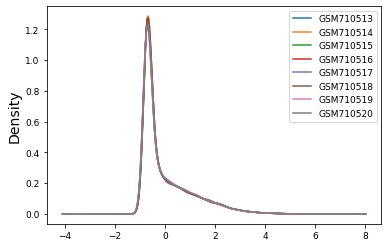

In [13]:
scale(mylog(df)).plot(kind='kde')

In [21]:
#dfg = df.loc[df.index.drop_duplicates(keep=False)]
dfg = df.groupby(df.index).agg('mean')

In [22]:
dfs = quantile_normalize(scale(mylog(dfg)))

In [24]:
dfs.to_csv('data/%s/%s_data.csv' % (g, g))

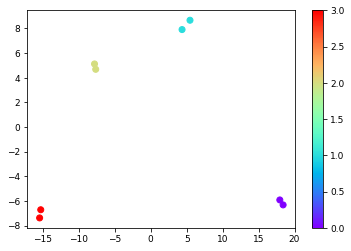

In [23]:
Xp = PCA(2).fit_transform(dfs.T)
plt.scatter(Xp[:,0], Xp[:,1], c=times, cmap='rainbow')
plt.colorbar()

## Ultraset

In [53]:
# df = pd.read_csv('data/GSE102348/GSE102348_raw_data.csv', index_col=0)
# ph = pd.read_csv('data/GSE102348/GSE102348_metadata.csv', index_col=0)


#df_e = key2ENTREZ(df, key="ensemblgene", species='mouse')
#df_e = log_aggregation(df_e, method='mean')
#df_e.to_csv('data/GSE127927/GSE127927_data.csv')

Max number of ENTREZ across keys: 1


In [142]:
#df_e.groupby('Gene ID').sum().to_csv('data/GSE102348/GSE102348_raw_data.csv')

# df_e = df_e.groupby('Gene ID').sum()

# fpkm_thr = 1. #recommended by https://www.biostars.org/p/358433/
# percentage_thr = 0.5 #chosen from looking at plot below

# df_filtered = df_e[(df_e > fpkm_thr).sum(1) > df_e.shape[1] * percentage_thr]
# print(df_filtered.shape)
# #np.log2(df_filtered + 1.).plot(kind='hist', bins=40);
# df_filtered_log = np.log2(df_filtered + 1.)

# df_filtered_log.to_csv('data/GSE102348/GSE102348_data.csv')

(11132, 34)


In [7]:
drop_columns = ['geo_accession', 'status', 'submission_date', 'last_update_date',
                'contact_city', 'contact_state', 'contact_zip/postal_code', 'contact_country',
                'supplementary_file', 'supplementary_file.1', 'contact_name', 'contact_email',
                'contact_phone', 'contact_institute', 'contact_address']

In [8]:
ultradf = {}

In [15]:
name = 'GSE54848'
ultraset = HUMAN_ULTRASET

In [16]:
# construct one GSE ultradf

path = os.path.join(data_folder, name)
#annotation = pd.read_csv(glob(path + '/*annotation.csv')[0], index_col=0)
pheno = pd.read_csv(glob(path + '/*metadata.csv')[0], index_col=0)
df = pd.read_csv(glob(path + '/*_rawdata.csv')[0], index_col=0)

for experiment in ultraset[name].keys():
    ultradf[name + '$' + experiment] = {}
    ultradf[name + '$' + experiment]['data'] = df[ultraset[name][experiment][0]]
    ultradf[name + '$' + experiment]['pheno'] = pheno.loc[ultraset[name][experiment][0]].drop(drop_columns, 1, 
                                                                                                errors='ignore')
    ultradf[name + '$' + experiment]['time'] = ultraset[name][experiment][1]

In [17]:
ultradf.keys()

dict_keys(['GSE28688$OSKM$HFF', 'GSE50206$OSKM$HDF', 'GSE50206$OSKM$ASC', 'GSE50206$OSKM$HA', 'GSE50206$OSKM$NHBE', 'GSE50206$OSKM$PrEC', 'GSE54848$OSKM$HDF'])

In [105]:
#ultradf_back[list(ultradf_back.keys())[-1]]['data']

In [106]:
#ultradf['GSE102348$OSKM$Gatad2a-/-']['data']

In [ ]:
ultradf = {}
#Contruct dataset of datasets
for name in tqdm(list(ultraset.keys())[-1]):
    path = os.path.join(data_folder, name)
    #annotation = pd.read_csv(glob(path + '/*annotation.csv')[0], index_col=0)
    pheno = pd.read_csv(glob(path + '/*metadata.csv')[0], index_col=0)
    df = pd.read_csv(glob(path + '/*_data.csv')[0], index_col=0)
    
    for experiment in ultraset[name].keys():
        ultradf[name + '$' + experiment] = {}
        ultradf[name + '$' + experiment]['data'] = df[ultraset[name][experiment][0]]
        ultradf[name + '$' + experiment]['pheno'] = pheno.loc[ultraset[name][experiment][0]].drop(drop_columns, 1, 
                                                                                                  errors='ignore')
        ultradf[name + '$' + experiment]['time'] = ultraset[name][experiment][1]
            

In [74]:
ukeys = list(ultradf.keys())
ukeys

['GSE114581$OSKM+dox_mef', 'GSE114581$OSKM-dox_mef']

In [76]:
#look up
key = ukeys[0]
print(key)

df = ultradf[key]['data']
labels = ultradf[key]['pheno']['title'].values

time = ultradf[key]['time']

for t, g, l in zip(time, df.columns, labels):
    print(t, g, l)

GSE114581$OSKM+dox_mef
0.5 GSM3145302 mef 12 hours with dox
1 GSM3145303 mef 24 hours with dox
1.5 GSM3145304 mef 36 hours with dox
2 GSM3145305 mef 48 hours with dox
2.5 GSM3145306 mef 60 hours with dox
3 GSM3145307 mef 72 hours with dox
6 GSM3145308 mef 144 hours with dox
12 GSM3145309 mef 288 hours with dox
18 GSM3145310 mef 432 hours with dox


In [77]:
print(" max value:", df.max().max(), '\n', "min value:", df.min().min())
df

 max value: 161911.85888 
 min value: 0.064639961


,GSM3145302,GSM3145303,GSM3145304,GSM3145305,GSM3145306,GSM3145307,GSM3145308,GSM3145309,GSM3145310
ENTREZ_GENE_ID,,,,,,,,,
100017,307.230186,299.594437,339.975504,334.619712,314.362543,283.202052,162.205241,175.362062,269.050976
100019,323.441914,382.080435,479.904615,382.315261,405.423305,353.625283,341.010368,246.847745,191.859873
100036538,25.641358,3.538346,20.255223,1.481723,7.503237,22.733128,11.170826,25.254699,1.189386
100036539,1.358878,15.619967,3.246890,18.560005,5.476268,0.902094,1.139609,2.876863,0.869336
100036541,1.136168,4.488629,16.154903,0.980095,2.233746,1.041617,4.187962,1.196132,1.525422
...,...,...,...,...,...,...,...,...,...
99890,144.533900,139.913317,155.546488,181.749234,181.693047,145.426918,148.659981,62.334714,81.707395
99899,44.909420,3.533419,52.232474,31.035013,24.572417,24.458644,62.586457,215.745370,293.497415
99929,2429.646598,1963.804206,2355.189528,2332.957028,2577.083832,2718.315699,2116.509902,2705.466522,2596.770935


In [78]:
df = mylog(df)
print(" max value:", df.max().max(), '\n', "min value:", df.min().min())
df

 max value: 17.30485804133562 
 min value: 0.09036562359710286


,GSM3145302,GSM3145303,GSM3145304,GSM3145305,GSM3145306,GSM3145307,GSM3145308,GSM3145309,GSM3145310
ENTREZ_GENE_ID,,,,,,,,,
100017,8.267864,8.231675,8.413524,8.390684,8.300868,8.150773,7.350544,7.462396,8.077088
100019,8.341816,8.581504,8.909607,8.582388,8.666839,8.470152,8.417896,7.953310,7.591409
100036538,4.735596,2.182167,4.409745,1.311342,3.088012,4.568830,3.605355,4.714504,1.130526
100036539,1.238101,4.054846,2.086407,4.289835,2.695163,0.927588,1.097347,1.954890,0.902526
100036541,1.095025,2.456446,4.100549,0.985570,1.693206,1.029712,2.375168,1.134965,1.336525
...,...,...,...,...,...,...,...,...,...
99890,7.185211,7.138664,7.290447,7.513722,7.513278,7.194037,7.225545,5.984925,6.369944
99899,5.520718,2.180600,5.734235,5.001578,4.676517,4.670084,5.990648,7.759857,8.202111
99929,11.247124,10.940170,11.202240,11.188562,11.332083,11.409028,11.048153,11.402195,11.343059


# Look at data

## Description of one ds

In [6]:
ultradf_back.keys()

dict_keys(['GSE67462$OSKM', 'GSE38509$OSKM', 'GSE38509$OSK', 'GSE38509$GFP', 'GSE116309$OKMS', 'GSE116309$OK+9MS', 'GSE46321$C/EBPα+ OSKM', 'GSE46321$C/EBPα- OSKM', 'GSE10871$OSKM', 'GSE21757$OKMS', 'GSE103979$Oct4+SK', 'GSE103979$Oct6+SK', 'GSE103979$Oct4+defSox+K', 'GSE103979$GFP', 'GSE114581$OSKM+dox_mef', 'GSE114581$OSKM-dox_mef', 'GSE127927$7F-Esrrb', 'GSE127927$7F-Glis1', 'GSE127927$7F-Jdp2', 'GSE127927$7F-Kdm2b', 'GSE127927$7F-Mkk6', 'GSE127927$7F-Nanog', 'GSE127927$7F-Sall4', 'GSE127927$7F', 'GSE127927$GFP', 'GSE102348$OSKM$Gatad2a-/-', 'GSE102348$OSKM$Mbd3f/-', 'GSE102348$OSKM$WT-1', 'GSE102348$OSKM$WT-2'])

In [22]:
key = 'GSE102348$OSKM$WT-2'
experiment = ultradf_back[key]
data = experiment['data']
pheno = experiment['pheno']
time = experiment['time']

## multiple description

In [5]:
ultradf_back.keys()

dict_keys(['GSE67462$OSKM', 'GSE38509$OSKM', 'GSE38509$OSK', 'GSE38509$GFP', 'GSE116309$OKMS', 'GSE116309$OK+9MS', 'GSE46321$C/EBPα+ OSKM', 'GSE46321$C/EBPα- OSKM', 'GSE10871$OSKM', 'GSE21757$OKMS', 'GSE103979$Oct4+SK', 'GSE103979$Oct6+SK', 'GSE103979$Oct4+defSox+K', 'GSE103979$GFP', 'GSE114581$OSKM+dox_mef', 'GSE114581$OSKM-dox_mef', 'GSE127927$7F-Esrrb', 'GSE127927$7F-Glis1', 'GSE127927$7F-Jdp2', 'GSE127927$7F-Kdm2b', 'GSE127927$7F-Mkk6', 'GSE127927$7F-Nanog', 'GSE127927$7F-Sall4', 'GSE127927$7F', 'GSE127927$GFP', 'GSE102348$OSKM$Gatad2a-/-', 'GSE102348$OSKM$Mbd3f/-', 'GSE102348$OSKM$WT-1', 'GSE102348$OSKM$WT-2'])

No handles with labels found to put in legend.


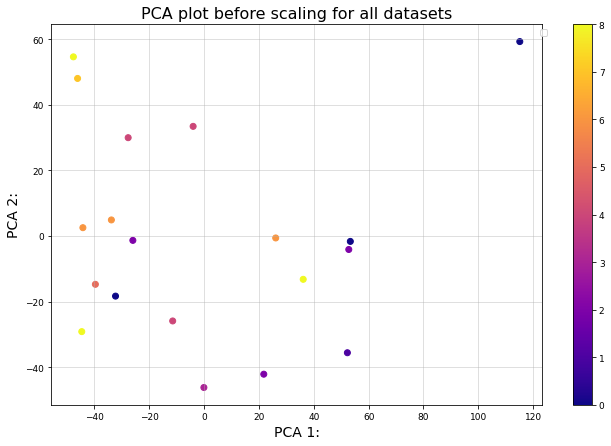

In [29]:
filt = ['GSE102348$OSKM$Mbd3f/-', 'GSE102348$OSKM$WT-1', 'GSE102348$OSKM$WT-2']
pca1 = np.array([])
pca2 = np.array([])
labels = []
for key in ultradf_back.keys():
    if key in filt:
        df = ultradf_back[key]['data']
        lab = ultradf_back[key]['time'] #list(map(str, ultradf_back[key]['time'])) #ultradf_back[key]['time']
        # PCA before preprocessing
        pca = PCA(2)
        Xpca = pca.fit_transform(df.T)
        exp_var = pca.explained_variance_ratio_

        pca1 = np.concatenate([pca1, Xpca[:, 0]])
        pca2 = np.concatenate([pca2, Xpca[:, 1]])
        labels = labels + lab

plt.figure(figsize=(11,7))
#sns.scatterplot(x=pca1, y=pca2, hue=labels, palette='plasma')
plt.scatter(x=pca1, y=pca2, c=labels, cmap='plasma')
plt.title('PCA plot before scaling for all datasets')
plt.xlabel('PCA 1:') #%0.3f ' % exp_var[0])
plt.ylabel('PCA 2:') #%0.3f ' % exp_var[1])
plt.legend(bbox_to_anchor=(1.02, 1))
plt.grid(alpha=0.5)
plt.colorbar()
plt.show()

# Preprocess data

In [12]:
rawdf = pd.read_csv(path + '/' + 'GSE103979_data.csv', index_col=0)

In [88]:
#new_df = df.copy()

In [14]:
rawdf = rawdf.drop('ensg', 1).set_index('name')

In [15]:
new_df = key2ENTREZ(rawdf, key='symbol')

Max number of ENTREZ across keys: 1


In [19]:
#new_df = log_aggregation(new_df, method='mean')
new_df
#new_df.to_csv(path + '/' + 'GSE103979_data.csv')

,GSM2787321,GSM2787269,GSM2787295,GSM2787270,GSM2787296,GSM2787271,GSM2787297,GSM2787272,GSM2787298,GSM2787273,GSM2787299,GSM2787274,GSM2787300,GSM2787275,GSM2787301,GSM2787276,GSM2787302,GSM2787277,GSM2787303,GSM2787278,...,GSM2787284,GSM2787310,GSM2787285,GSM2787311,GSM2787286,GSM2787312,GSM2787287,GSM2787313,GSM2787288,GSM2787314,GSM3381672,GSM3381673,GSM3381674,GSM3381675,GSM3381676,GSM3381677,GSM3381678,GSM3381679,GSM3381680,GSM3381681
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
71952,7.186861,6.864505,7.129571,6.797854,7.217842,6.948126,6.242730,6.939503,7.072707,7.321018,7.200677,6.701709,6.810879,7.258001,7.109254,6.928826,6.489772,6.696789,6.983049,6.895295,...,6.686500,7.058659,7.271281,7.235383,6.976223,6.957642,7.207121,6.945135,7.233254,7.152550,6.917903,6.899912,7.459735,7.118135,7.018650,6.723890,7.975007,7.476840,7.119928,7.213834
77532,8.395719,8.242134,8.328545,8.170667,8.108174,7.649415,8.423311,8.195664,8.239568,8.343688,8.331740,8.561545,8.456948,8.186906,8.230112,7.850687,8.439317,8.423987,8.486113,8.491597,...,8.562863,8.501814,8.166636,8.208467,8.392459,8.288778,8.327829,8.408262,8.404120,8.547683,8.591306,8.481586,8.210236,8.076845,7.753791,8.320874,8.148684,8.024693,8.138893,8.046053
16792,4.996765,7.344299,6.976014,7.641737,7.546771,7.614825,9.590900,9.475697,9.417128,9.509343,9.326789,7.137762,7.136318,6.730474,6.119665,7.758981,8.828790,5.232949,4.990239,6.195131,...,7.089681,7.157473,5.234657,5.316482,5.503341,5.422041,6.147432,5.943213,5.874462,5.085952,6.945961,7.253411,4.270867,4.348906,7.132260,8.516888,3.770313,3.635542,2.173413,1.117854
66254,8.526797,7.984536,7.790016,7.511576,7.649947,7.281564,7.386528,7.683199,7.591869,8.365075,8.374359,7.519509,7.536577,7.828977,7.642061,7.509836,7.404169,7.180588,7.451617,7.161173,...,7.776318,7.690386,7.845963,7.798760,7.597045,7.643155,7.670089,7.669183,7.634544,7.635076,7.793388,7.677255,7.879747,7.824584,7.466644,7.717050,7.843995,7.791577,7.764905,7.693222
18102,11.550188,9.313771,9.433433,10.999853,10.963728,10.571643,10.294259,10.412898,10.438977,10.310348,10.233174,9.381429,9.273622,10.822504,10.910303,10.629126,10.298310,10.182161,10.181560,10.152326,...,9.418196,9.399925,10.895285,11.014825,10.263345,10.507925,10.342690,10.359784,10.230503,10.426356,9.163119,9.063607,10.921091,10.936100,10.430167,10.232148,10.525111,10.411611,10.327347,10.405287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57444,9.662952,10.133464,9.979485,9.514724,9.380210,10.099832,9.674135,10.516051,10.538948,10.326791,10.363181,10.262821,10.181264,9.447994,9.596753,9.858933,9.255969,9.962417,9.905180,10.028020,...,10.019041,10.016622,9.382860,9.420872,9.857803,9.884930,9.828962,9.805709,9.891105,10.028028,10.023885,9.959620,9.531470,9.395564,9.935998,9.297434,9.702655,9.743100,9.773489,9.744186
216154,7.061236,7.751865,7.575090,6.737018,6.491034,6.989215,6.658745,6.257029,5.948007,5.796589,5.821278,7.944195,7.990534,6.878005,6.697695,7.242752,7.166516,7.032295,6.488653,6.352271,...,7.628509,7.515136,6.497284,6.512029,6.790929,6.482224,6.261343,6.324709,5.845227,5.903642,7.595042,7.412290,6.777198,6.756840,6.923655,6.888761,6.030671,5.680435,5.350148,5.681457
66632,5.268877,6.342710,6.643409,5.750479,5.818867,5.099941,5.472153,4.731516,4.515034,3.420046,3.953218,5.191752,5.595462,4.576940,3.878429,5.094715,4.740150,1.124915,2.790781,0.000000,...,6.873229,6.777217,6.259176,6.698168,5.710502,5.498271,4.967354,4.456321,4.749053,3.675026,6.753002,6.306660,6.566978,5.993039,4.475572,5.165969,3.887006,2.973960,2.506193,3.003860


In [349]:
new_df = scale(new_df)

In [350]:
scaled_df = quantile_normalize(new_df)

In [351]:
scaled_df

,GSM542375,GSM542376,GSM542377,GSM542378,GSM542379,GSM542380,GSM542381
11287,-1.285572,-1.271782,-1.319292,-1.327807,-1.308615,-1.277782,-1.236250
11298,-0.591282,-0.623646,-0.699861,-0.709059,-0.812647,-0.722054,-0.723686
11302,0.032676,-0.262706,-0.337275,-0.287208,-0.319012,-0.315895,-0.156514
11303,0.249606,0.932225,1.604214,1.337479,1.393442,0.953834,1.575532
11304,-0.787500,-0.803343,-0.906787,-0.880153,-0.914640,-0.834406,-0.851611
...,...,...,...,...,...,...,...
100044927,0.105728,0.234639,-0.014167,0.065637,0.082844,-0.195122,-0.692880
100046593,-0.983696,-0.999545,-0.964211,-0.956835,-1.321725,-0.953767,-1.049572
100093623,-0.802714,-0.684172,-1.337616,-1.081348,-0.705645,-1.140463,-1.469799
100126879,-1.992451,-2.147942,-2.002385,-2.060513,-1.925755,-1.991916,-2.060513


In [17]:
scaled_df.to_csv(path + '/' + 'scaled_df.csv')

NameError: name 'scaled_df' is not defined

### look after preprocessing

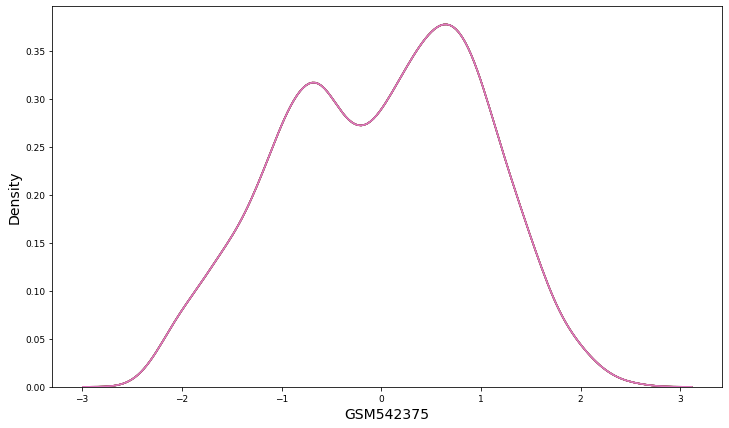

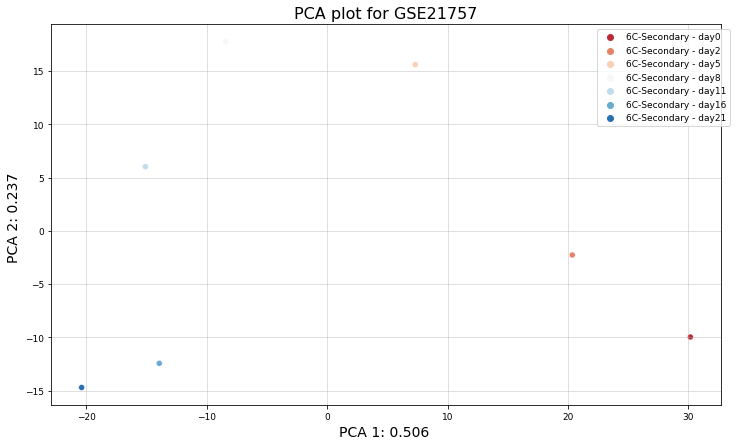

In [352]:
plt.figure(figsize=(12,7))
for c in scaled_df.columns:
    sns.kdeplot(scaled_df[c])
    
# PCA After preprocessing
pca = PCA(2)
Xpca = pca.fit_transform(scaled_df.T)
exp_var = pca.explained_variance_ratio_

plt.figure(figsize=(12,7))
sns.scatterplot(x=Xpca[:,0], y=Xpca[:,1], hue=labels, palette='RdBu')
plt.title('PCA plot for %s' % name)
plt.xlabel('PCA 1: %0.3f ' % exp_var[0])
plt.ylabel('PCA 2: %0.3f ' % exp_var[1])
plt.legend(bbox_to_anchor=(1.02, 1))
plt.grid(alpha=0.5)
plt.show()

In [81]:
#rewrite
#ultradf[key]['data'] = scaled_df

In [356]:
for key in ultradf.keys():
    print(ultradf[key]['data'].max().max())

5.269674318128498
4.361618246019884
4.298946049014105
4.336529850750572
3.1209273521574663
3.0764234202349323
3.4212570523210166
3.425997826819126
3.110904905041613
2.6828012595118844


In [51]:
#save after all
#save_structure(ultradf, path=os.path.join(data_folder, 'ultradf.json'))

In [9]:
ultradf[e]['data'] = pd.read_csv(StringIO(ultradf[e]['data']), index_col=0)

# Adding data

In [18]:
ultradf_back = load_structure('./data/ultradf_human.json')

In [19]:
ultradf_back.keys()

dict_keys(['GSE89455$OSKM$HDF', 'GSE89455$OSKM$HAdMSC', 'GSE89455$OSKM$HA', 'GSE89455$OSKM$HBEC', 'GSE89455$OSKM$HPrEC'])

In [95]:
#print(ultradf_back.keys())
#ultradf_back['GSE103979$GFP']['data'].plot(kind='kde')

## Add to ultradf

In [20]:
#add new
for e in list(ultradf.keys()):
    ultradf_back[e] = ultradf[e]
    ultradf_back[e]['data'].index.rename('index', inplace=True)

In [22]:
len(ultradf_back.keys())

12

In [23]:
ultradf_back['GSE28688$OSKM$HFF']['time']

[0, 0, 1, 1, 2, 2, 3, 3]

In [24]:
save_structure(ultradf_back, path='./data/ultradf_human_v3.json')

# plot all

In [71]:
ultradf = load_structure('./data/ultradf_v4.json')

In [73]:
ultradf.keys()

dict_keys(['GSE67462$OSKM', 'GSE38509$OSKM', 'GSE38509$OSK', 'GSE38509$GFP', 'GSE116309$OKMS', 'GSE116309$OK+9MS', 'GSE46321$C/EBPα+ OSKM', 'GSE46321$C/EBPα- OSKM', 'GSE10871$OSKM', 'GSE21757$OKMS', 'GSE103979$Oct4+SK', 'GSE103979$Oct6+SK', 'GSE103979$Oct4+defSox+K', 'GSE103979$GFP', 'GSE114581$OSKM+dox_mef', 'GSE114581$OSKM-dox_mef', 'GSE127927$7F-Esrrb', 'GSE127927$7F-Glis1', 'GSE127927$7F-Jdp2', 'GSE127927$7F-Kdm2b', 'GSE127927$7F-Mkk6', 'GSE127927$7F-Nanog', 'GSE127927$7F-Sall4', 'GSE127927$7F', 'GSE127927$GFP', 'GSE102348$OSKM$Gatad2a-/-', 'GSE102348$OSKM$Mbd3f/-', 'GSE102348$OSKM$WT-1', 'GSE102348$OSKM$WT-2'])

In [ ]:
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
import matplotlib.gridspec

for key in tqdm(ultradf.keys()):

    experiment = ultradf[key]
    df = experiment['data']
    pheno = experiment['pheno']
    time = experiment['time']

    labels = list(map(str, time))

    #Cluster map
    g = sns.clustermap(df.corr(), annot=False, figsize=(16,8),
                        yticklabels=labels, xticklabels=labels,
                        metric='correlation', method='complete',
                        cbar_kws = {"use_gridspec":False, "shrink": 0.5},
                        cmap='RdBu_r',annot_kws={"size": 8})

    # set the gridspec to only cover half of the figure
    g.gs.update(left=0.05, right=0.5)
    g.fig.suptitle(key.replace('$', ' '), fontsize=17, y=1.03)

    #create new gridspec for the right part
    gs2 = matplotlib.gridspec.GridSpec(2, 1, left=0.6, height_ratios=(2,3), hspace=0.3)
    # create axes within this new gridspec
    ax2 = g.fig.add_subplot(gs2[0])
    ax3 = g.fig.add_subplot(gs2[1])

    # Distributions
    for i, c in enumerate(df.columns):
        sns.kdeplot(df[c], label=labels[i], ax=ax2,  palette='plasma')
    ax2.set_xlabel('Expression value')

    # PCA before preprocessing
    pca = PCA(2)
    Xpca = pca.fit_transform(df.T)
    exp_var = pca.explained_variance_ratio_

    sns.scatterplot(x=Xpca[:,0], y=Xpca[:,1], hue=labels, palette='plasma', ax=ax3,)
    ax3.set_title('PCA plot', fontsize=14)
    ax3.set_xlabel('PCA 1: %0.3f %%' % (exp_var[0] * 100))
    ax3.set_ylabel('PCA 2: %0.3f %%' % (exp_var[1] * 100))
    ax3.legend(bbox_to_anchor=(1.02, 1))
    ax3.grid(alpha=0.5)

    g.fig.savefig('figs/quality_control/%s_qq.pdf' % key.replace('/','|'), format='pdf', dpi=300, bbox_inches='tight')